# Week 1 Notebook

## Imports

In [16]:
#Main Imports
import cv2
import numpy as np
import os
from distances import find_distance, distance_metrics
from histogram import calc_3d_hist, calc_1d_hist
import get_images_and_labels
import evaluation as eval
import pickle
import glob


In [17]:
#Notebook imports
import matplotlib.pyplot as plt
import random

In [18]:
cur_path = os.getcwd()

# Available color_spaces
color_spaces = {
"RGB": cv2.COLOR_BGR2RGB,
"HSV": cv2.COLOR_BGR2HSV,
"YCRCB": cv2.COLOR_BGR2YCrCb,
"LAB": cv2.COLOR_BGR2LAB
}

In [19]:
DISPLAY_ALL = False
CONVERT_RGB = False

In [20]:
if CONVERT_RGB : 
    # Get the 3 images dataset or 
    if DISPLAY_ALL:
        museum_imgs = [cv2.cvtColor(image, color_spaces["RGB"]) for image in get_images_and_labels.get_museum_dataset(cur_path)]
        query_set1_imgs = [cv2.cvtColor(image, color_spaces["RGB"]) for image in get_images_and_labels.get_query_set_images(cur_path, "qsd1")]
    query_set2_imgs = [cv2.cvtColor(image, color_spaces["RGB"]) for image in get_images_and_labels.get_query_set_images(cur_path, "qsd2")]
else:
    if DISPLAY_ALL:
        museum_imgs = get_images_and_labels.get_museum_dataset(cur_path)
        query_set1_imgs = get_images_and_labels.get_query_set_images(cur_path, "qsd1")
    query_set2_imgs = get_images_and_labels.get_query_set_images(cur_path, "qsd2")

#Get Query Set 2 Masks
query_set2_masks = [cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).astype("bool") for mask in get_images_and_labels.get_qsd2_masks(cur_path)]

In [21]:
if DISPLAY_ALL:
    f, axs = plt.subplots(1,3, figsize=(30,10))

    axs[0].imshow(random.choice(museum_imgs))
    axs[0].title.set_text("Museum Dataset")
    axs[1].imshow(random.choice(query_set1_imgs))
    axs[1].title.set_text("Query Dataset 1 ")
    axs[2].imshow(random.choice(query_set2_imgs))
    axs[2].title.set_text("Query Dataset 2")
    for ax in axs:
        ax.axis('off') 

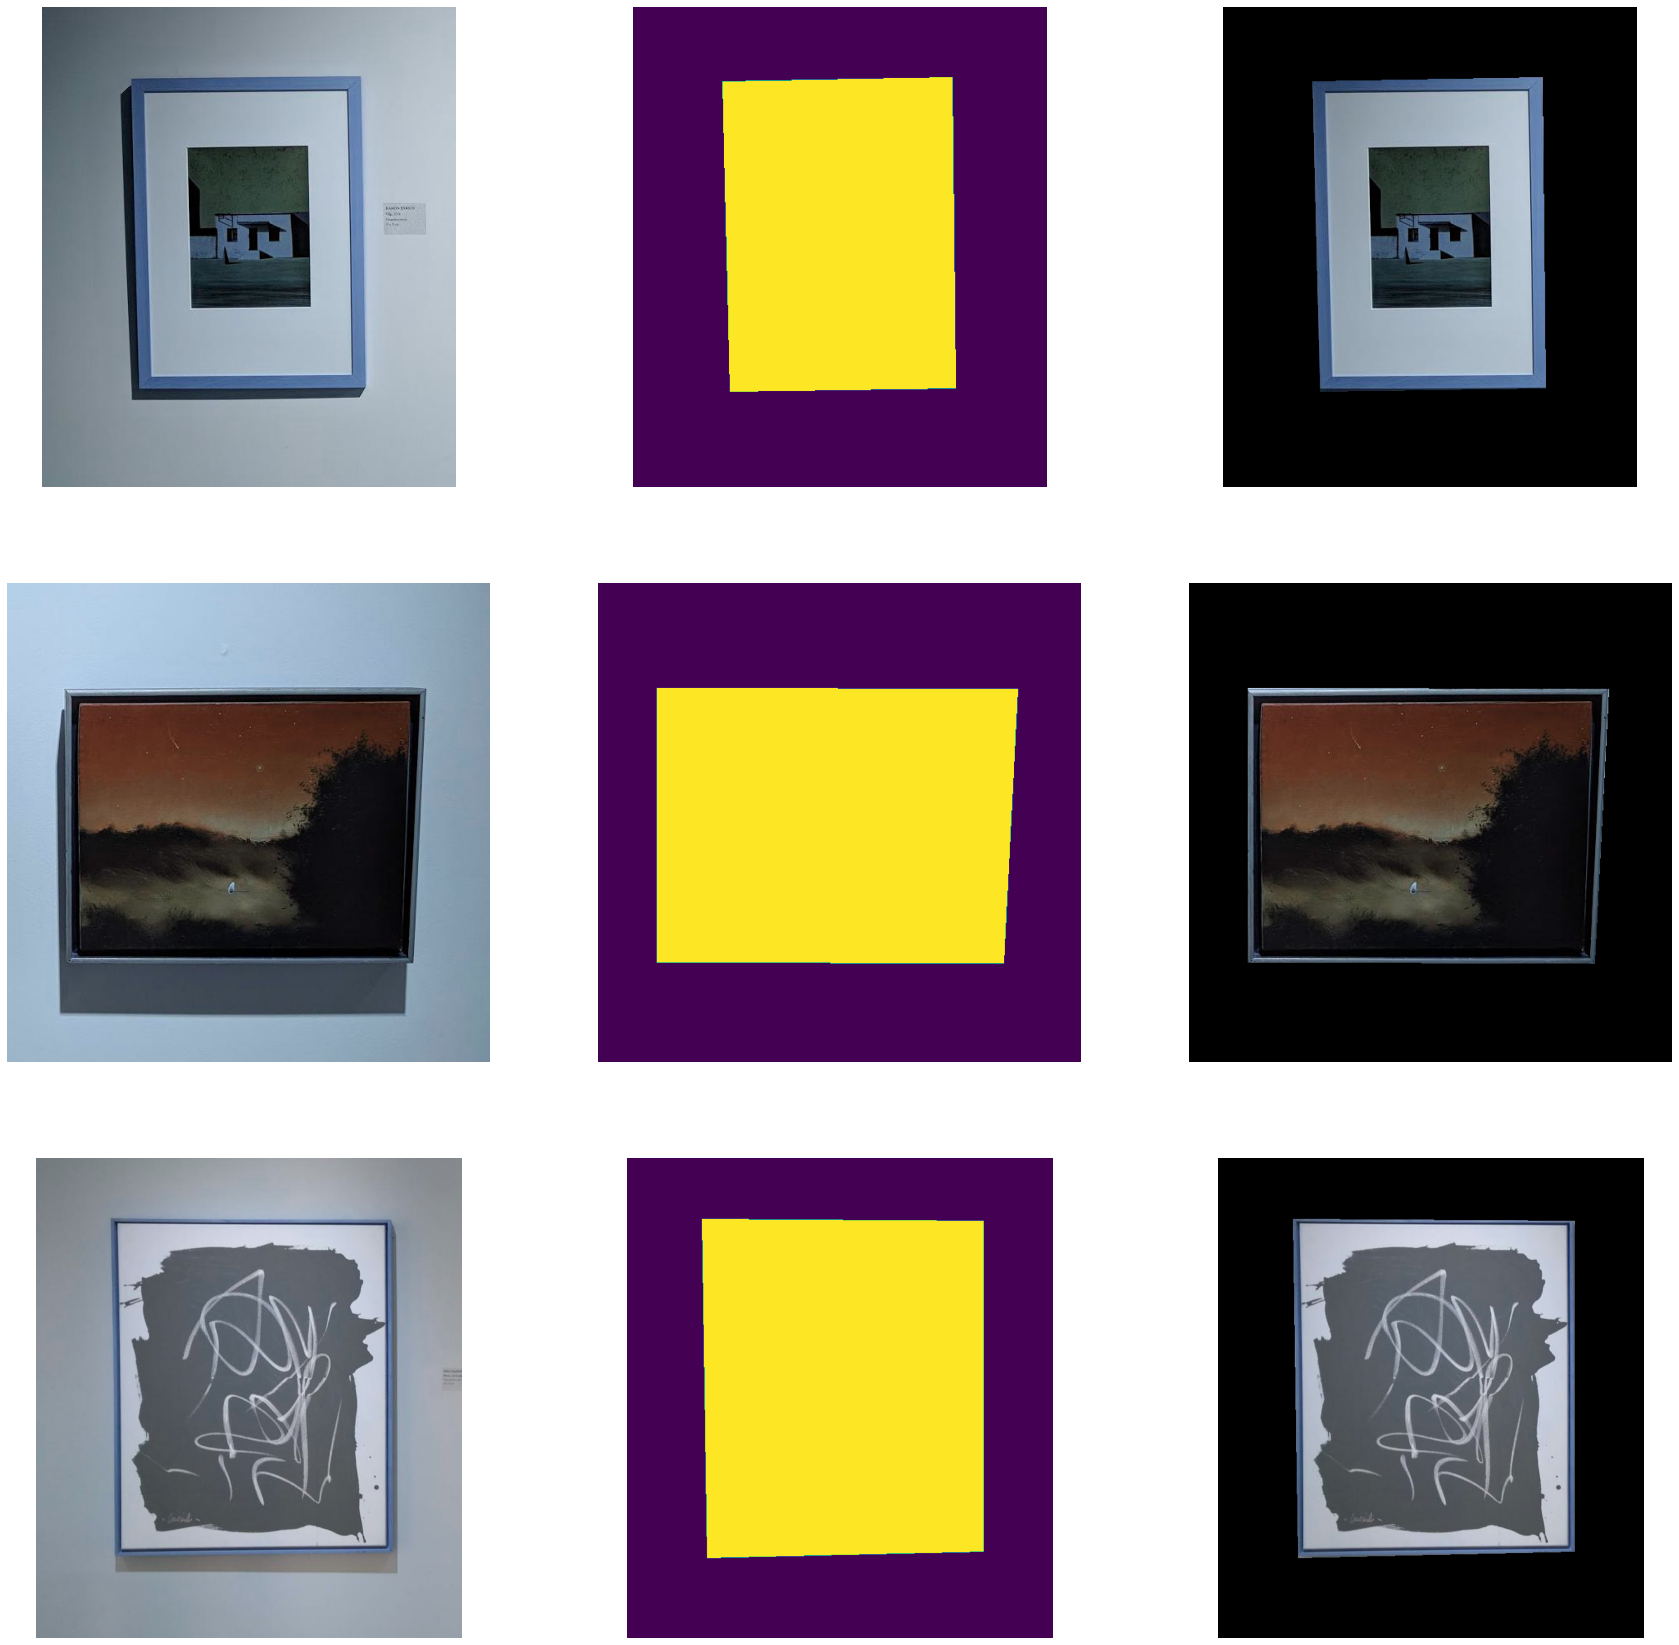

In [22]:
from itertools import product
f, axs = plt.subplots(3,3, figsize=(30,30))

for i in range(3):
    idx = random.randint(0,len(query_set2_imgs)-1)
    axs[i,0].imshow(query_set2_imgs[idx])
    axs[i,1].imshow(query_set2_masks[idx])
    axs[i,2].imshow(query_set2_imgs[idx]*query_set2_masks[idx][:,:,None], cmap="gray")

for i,j in product(range(3), range(3)):
    axs[i,j].axis('off')

In [23]:
def background_removal(image, ):
    """
    Remove background from image.
    This functions takes an image as input and return a mask of where it believes the picture is.
    Parameters
    ----------
    image : numpy array
            An array containing the image you want to remove the background.
    Returns
    -------
    mask : numpy array
            The mask corresponding to the believed position of the painting on the image.
    """

    LIMIT = 10

    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    h, w = image.shape
    mask = np.zeros_like(image) + 1

    for i in range(h):
        for j in range(w-1):
                if abs(int(image[i,j]) - int(image[i,j+1])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break
        for j in range(w-1,0,-1):
                if abs(int(image[i,j]) - int(image[i,j-1])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break
    for j in range(w):
        for i in range(h-1):
                if abs(int(image[i,j]) - int(image[i+1,j])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break
        for i in range(h-1,0,-1):
                if abs(int(image[i-1,j]) - int(image[i,j])) <= LIMIT:
                        mask[i,j] = 0
                else:
                        break

    return mask


In [24]:
def enhance_mask(mask):
    num_labels, im_labels = cv2.connectedComponents(mask)
    
    max_area, best_label = 0 , -1
    for label in range(num_labels):
        #If the background area is larger than the picture, we don't want the background
        if im_labels[0,0] == label:
            continue

        area = np.sum(im_labels == label)
        if area > max_area:
            best_label = label
            max_area = area
    
    enhanced_mask = np.array(im_labels == best_label)

    return enhanced_mask


In [25]:
def enhance_mask_2(mask):
    """
    Enhance mask quality by removing artifacts.
    This functions takes a mask as input and return a better quality mask by keeping only the biggest connected component.
    Parameters
    ----------
    mask : numpy array
            An array containing the mask you want to enhance.
    Returns
    -------
    mask : numpy array
            The enhanced mask.
    """
    num_labels, im_labels = cv2.connectedComponents(mask)
    
    max_area, best_label = 0 , -1
    for label in range(num_labels):
        #If the background area is larger than the picture, we don't want the background
        if im_labels[0,0] == label:
            continue

        area = np.sum(im_labels == label)
        if area > max_area:
            best_label = label
            max_area = area
    
    enhanced_mask = np.array(im_labels == best_label)

    contours,_ = cv2.findContours(enhanced_mask.astype("uint8"), 1, 2)
    cnt = contours[0]
    y,x,w,h = cv2.boundingRect(cnt)
    #print(w,mask.shape[1]-y-1,h, mask.shape[0]-x-1)
    w,h = min(w, mask.shape[1]-y-1), min(h, mask.shape[0]-x-1) 
    #print(w,h)

    can_improve = True

    while can_improve:
        #Top, right, bottom, left corners average binary value.
        borders = [np.mean(enhanced_mask[x,y:(y+w)]), np.mean(enhanced_mask[x:(x+h),y+w]) , np.mean(enhanced_mask[x+h,y:(y+w)]), np.mean(enhanced_mask[x:(x+h),y]) ]
        
        if np.min(borders) < 0.6:
            to_cut = np.argsort(borders)[0]
            if to_cut == 0:
                x += 1
                h -= 1
            elif to_cut == 1 :
                w -= 1
            elif to_cut == 2:
                h -=1
            elif to_cut == 3:
                y += 1
                w -= 1    
        else:
            can_improve = False

    straight_mask = np.zeros_like(enhanced_mask).astype("bool")
    straight_mask[x:(x+h),y:(y+w)] = True

    return straight_mask, (x,y,w,h)


In [26]:
def evaluate_mask(predicted_mask, true_mask):
    """
    Evaluates predicted mask precision, recall and F1-measure.
    Parameters
    ----------
    predicted_mask : numpy array
            An array containing the mask predicted by the background remover.
    true_mask : numpy array
            An array containing the true mask of the picture location.
    Returns
    -------
    precision : float
            Precision of the prediction = TP/(TP+FP)
    Recall : float
            Recall of the prediction = TP/(TP+FN)
    F1-Measure : float
            F1-Measure of the prediction = 2*(Precision . Recall)/(Precision + Recall)
    """

    #Compute the True Positives, False Positives, False Negatives
    TP = np.sum(true_mask*predicted_mask)
    FP = np.sum(predicted_mask) - TP
    FN = np.sum(true_mask) - TP

    #Compute the precision, recall, f1-score
    precision = TP / (TP+FP)
    recall = TP/ (TP+FN)
    f1_score = 2*precision*recall/(precision+recall)

    return precision, recall, f1_score

In [27]:
idx = random.randint(0,len(query_set2_imgs)-1)
idx = 11
image, mask = query_set2_imgs[idx], query_set2_masks[idx]
hist_1d = calc_1d_hist(image)
hist_3d = calc_3d_hist(image)

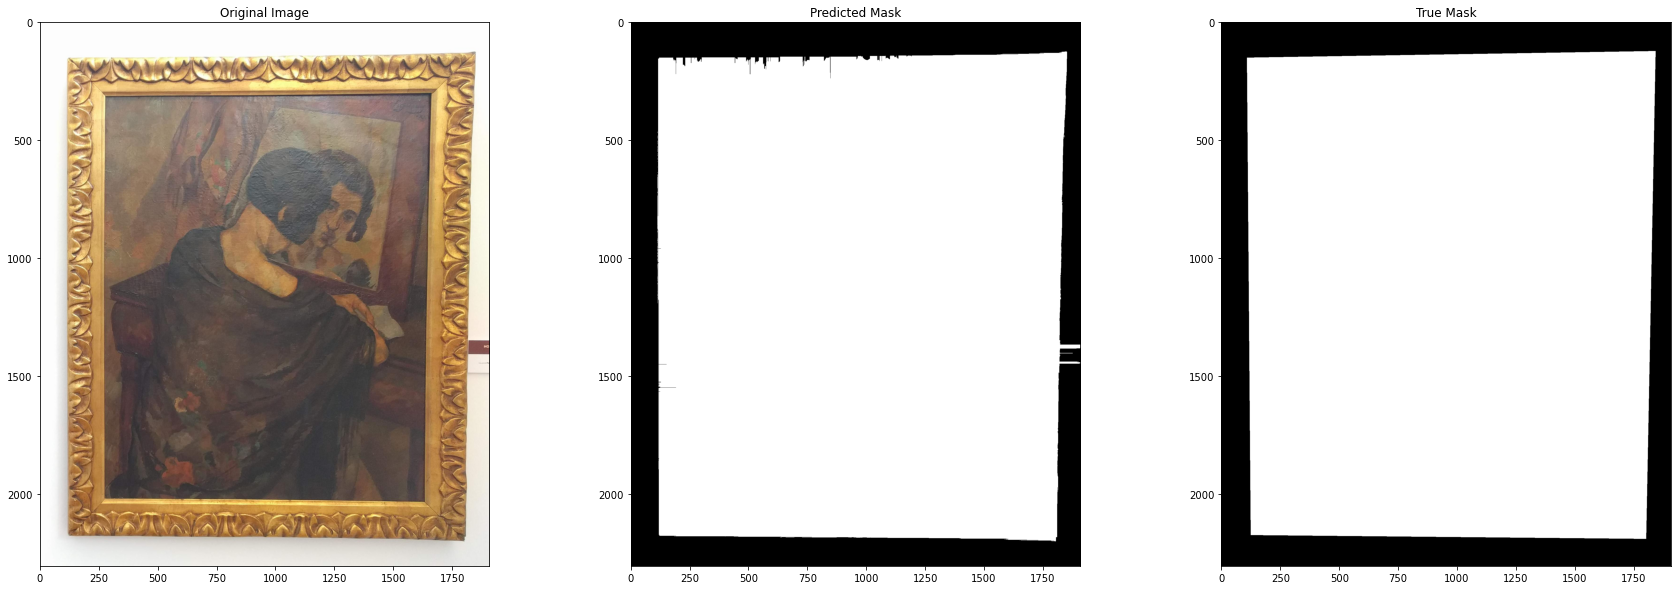

In [28]:
predicted_mask = background_removal(image)

f, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
axs[0].title.set_text("Original Image")
axs[1].imshow(predicted_mask, cmap="gray")
axs[1].title.set_text("Predicted Mask")
axs[2].imshow(mask, cmap="gray")
axs[2].title.set_text("True Mask")
plt.savefig("saved_images/predicted_mask.png")

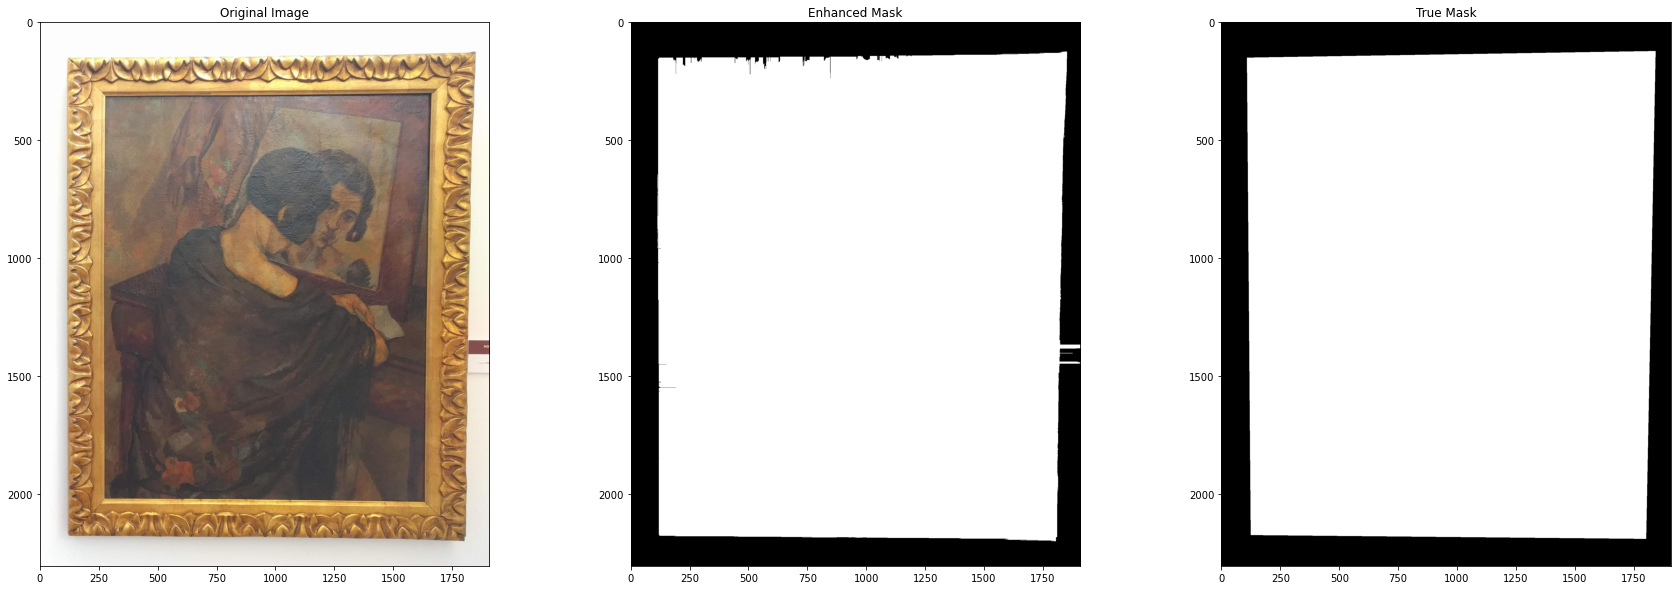

In [29]:
enhanced_mask = enhance_mask(predicted_mask)

f, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
axs[0].title.set_text("Original Image")
axs[1].imshow(enhanced_mask, cmap="gray")
axs[1].title.set_text("Enhanced Mask")
axs[2].imshow(mask, cmap="gray")
axs[2].title.set_text("True Mask")
plt.savefig("saved_images/enhanced_mask.png")


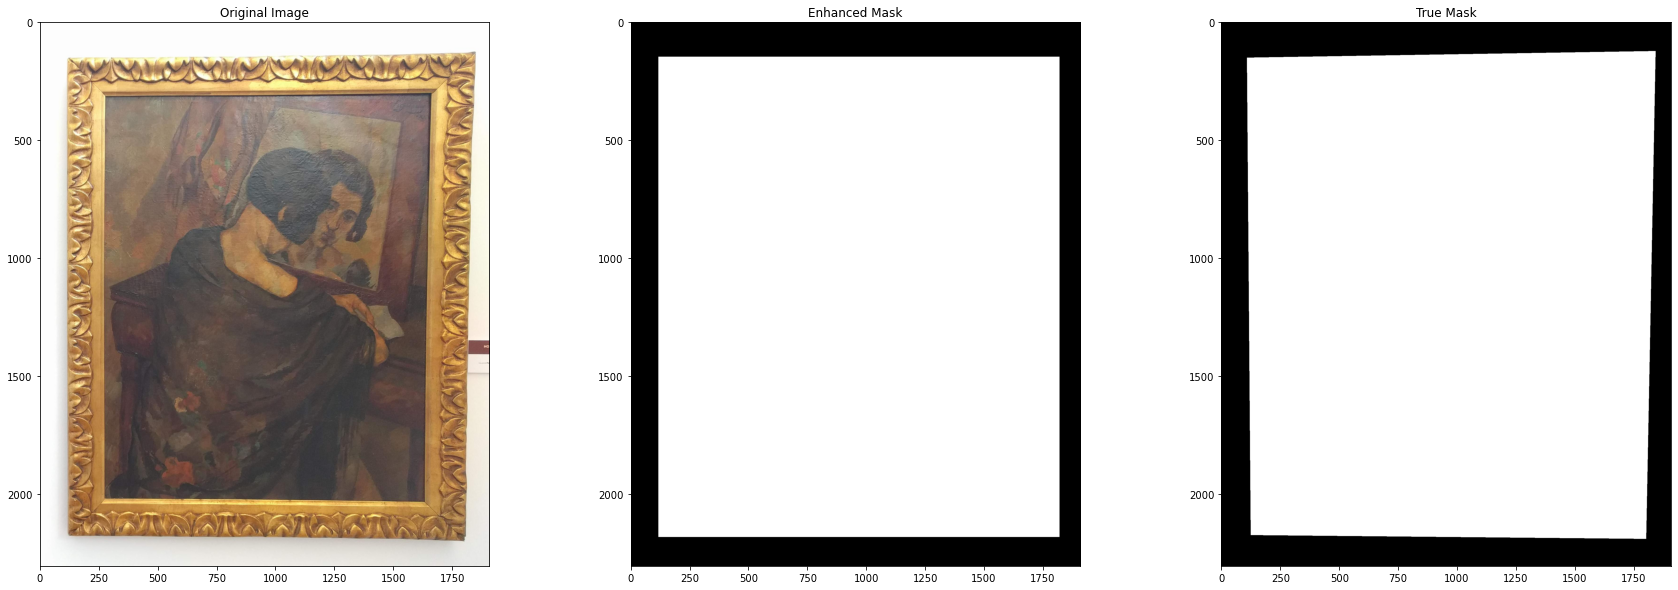

In [30]:
enhanced_mask_2,_ = enhance_mask_2(predicted_mask)

f, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
axs[0].title.set_text("Original Image")
axs[1].imshow(enhanced_mask_2, cmap="gray")
axs[1].title.set_text("Enhanced Mask")
axs[2].imshow(mask, cmap="gray")
axs[2].title.set_text("True Mask")
plt.savefig("saved_images/straight_mask.png")

In [31]:
print("First function : ", evaluate_mask(enhanced_mask,mask))
print("Second function : ", evaluate_mask(enhanced_mask_2,mask))

First function :  (0.9956734590805132, 0.994163429141537, 0.9949178711518971)
Second function :  (0.9956134844587362, 0.9884457673113637, 0.9920166786484543)


IndexError: index 1788 is out of bounds for axis 1 with size 1788

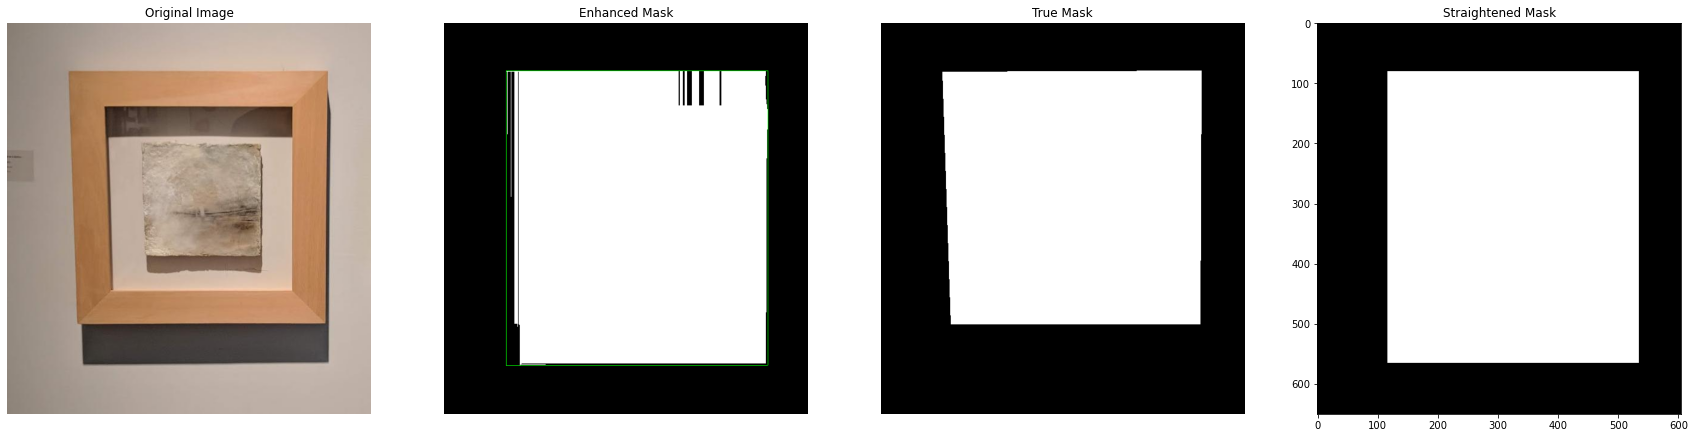

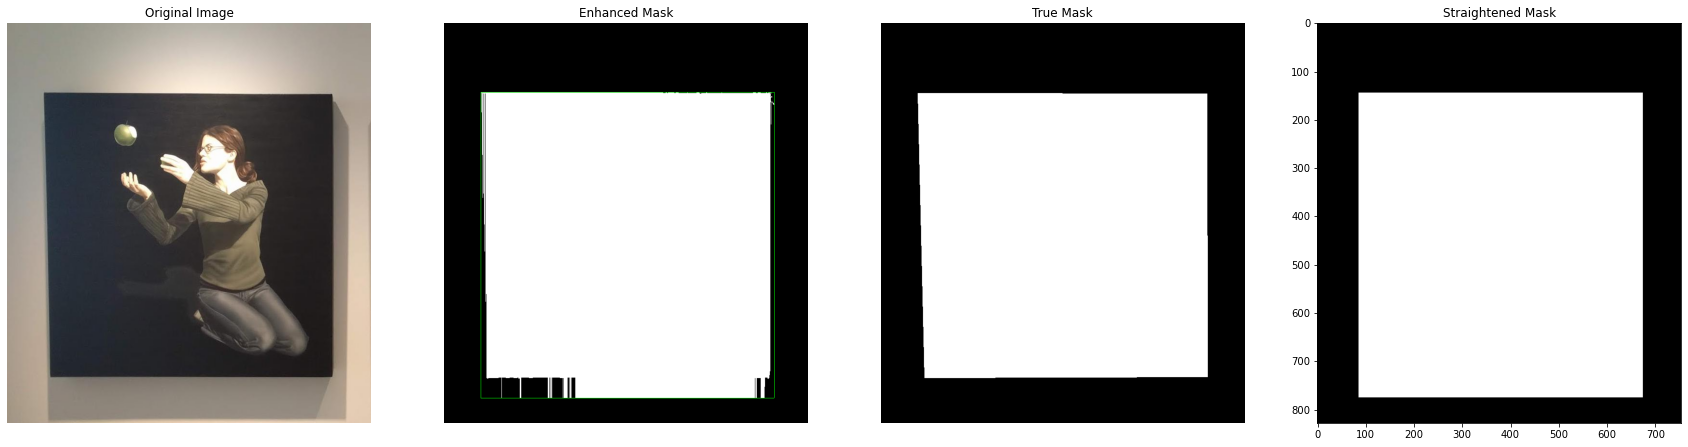

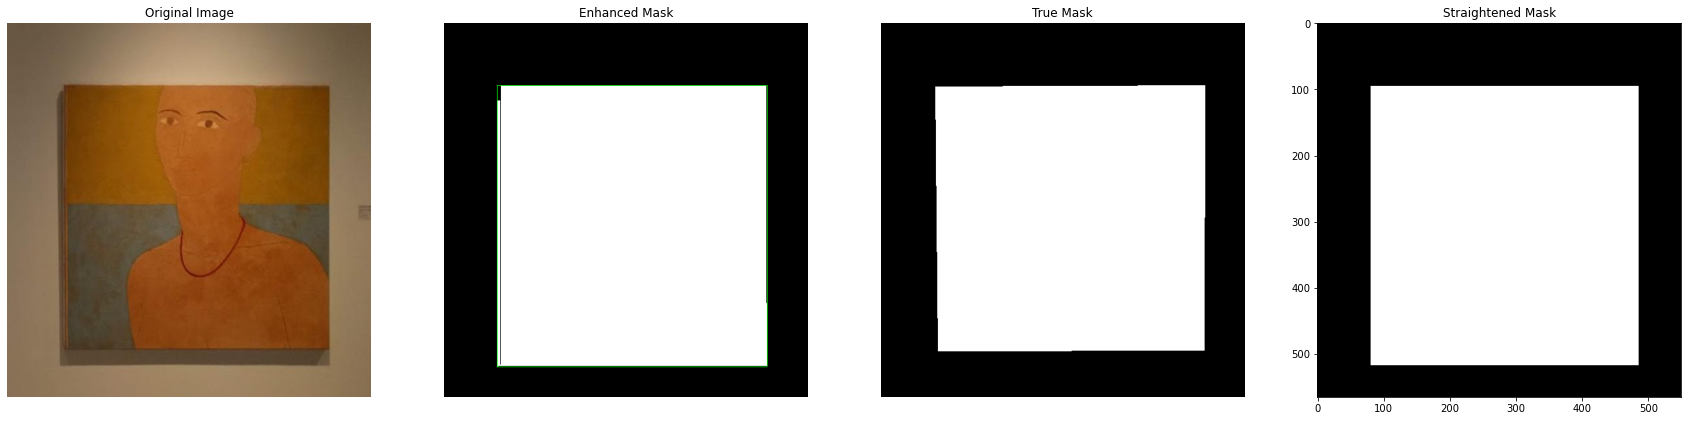

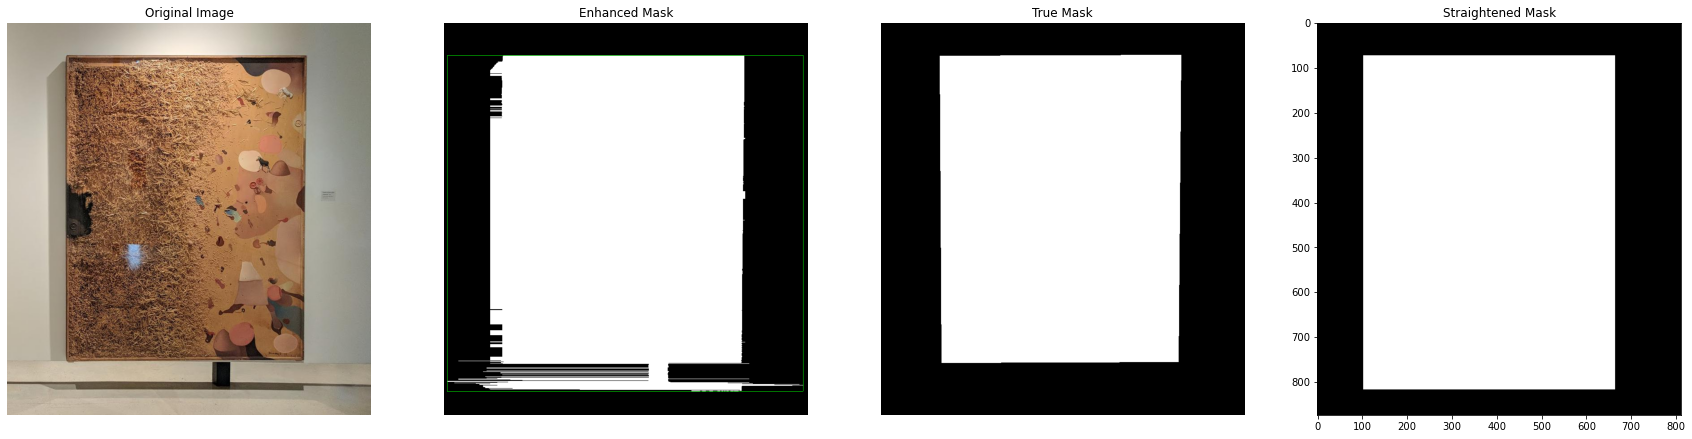

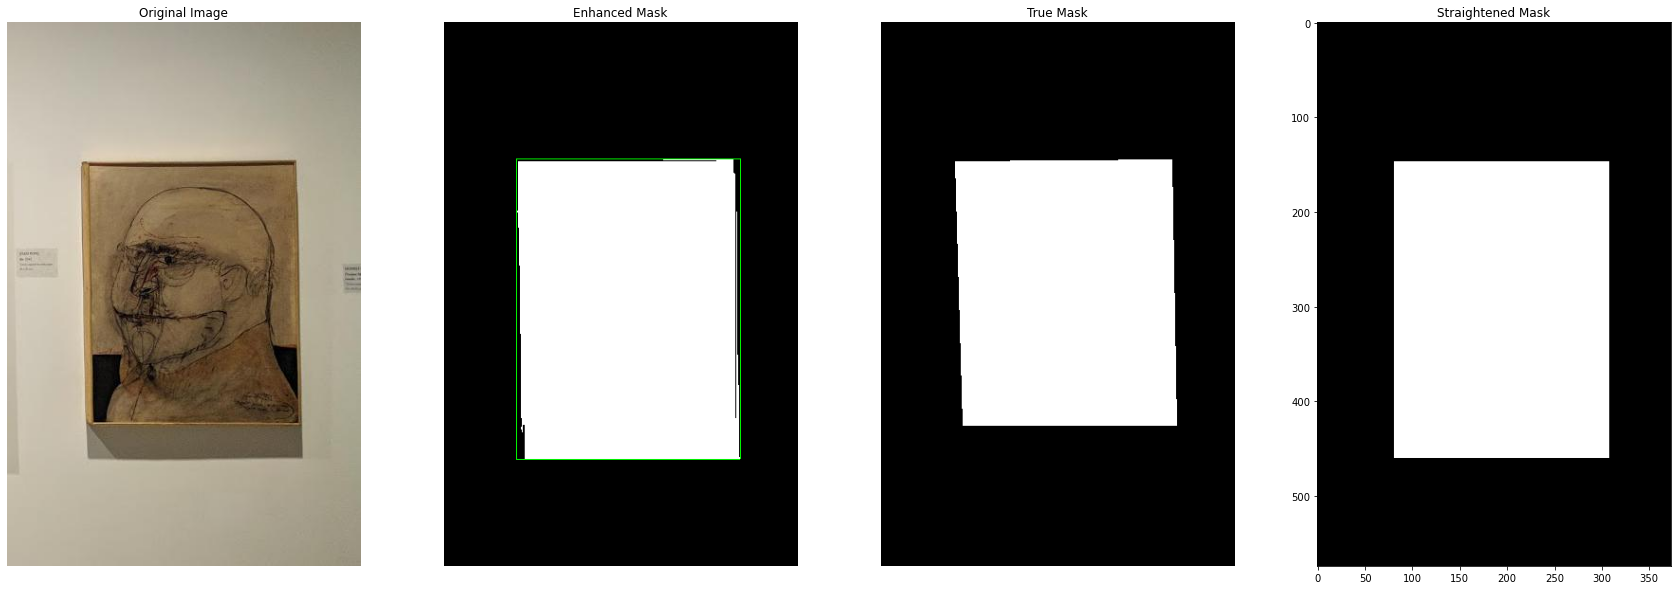

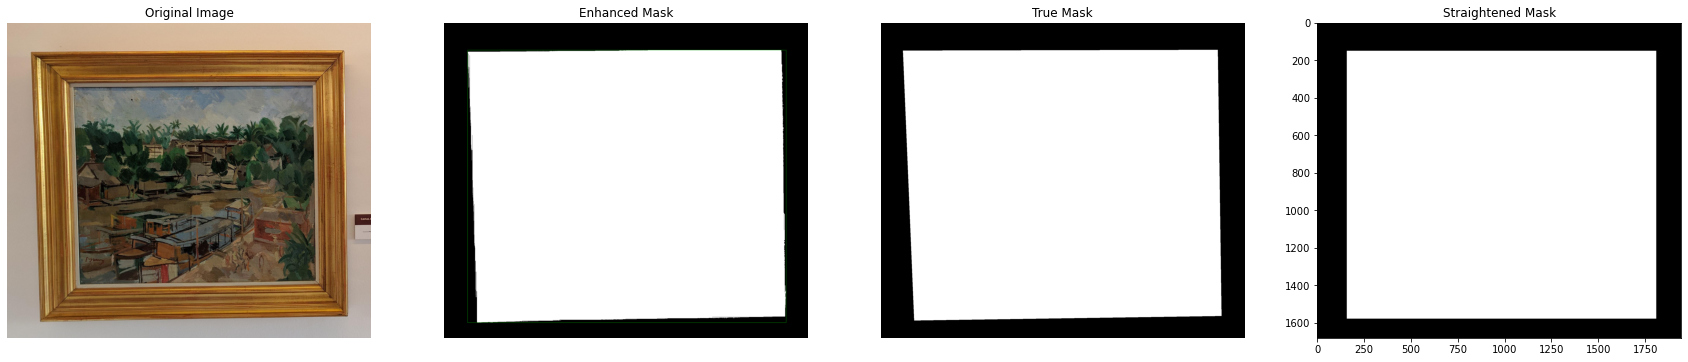

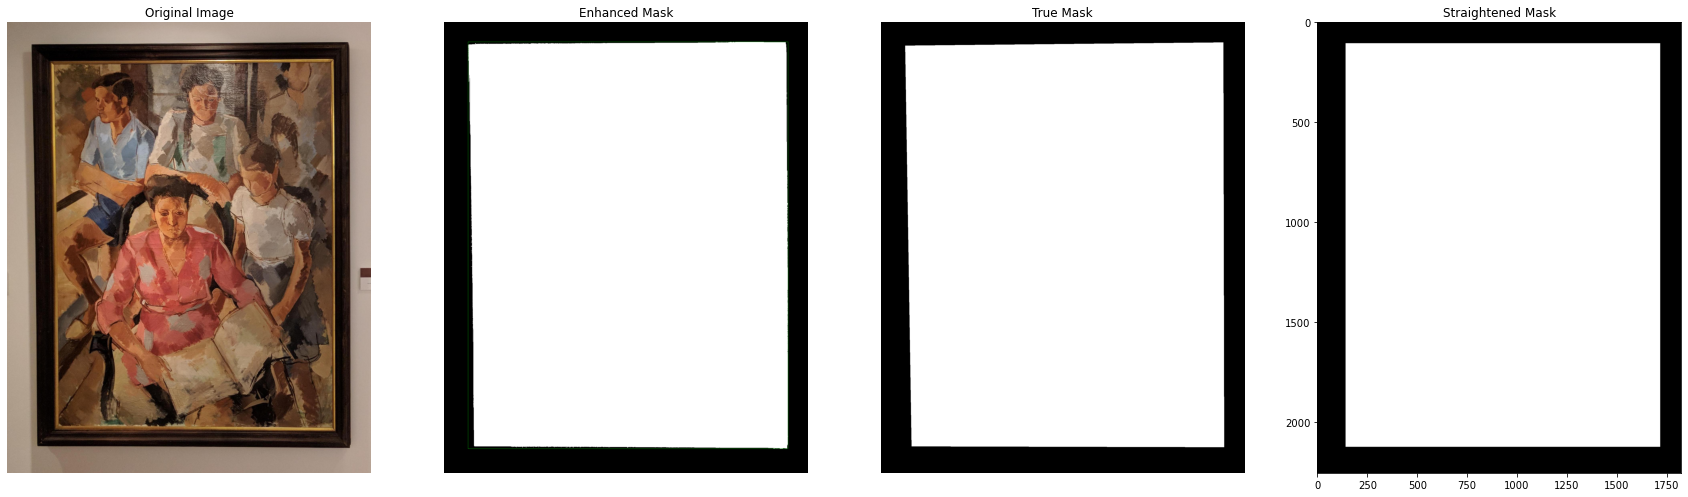

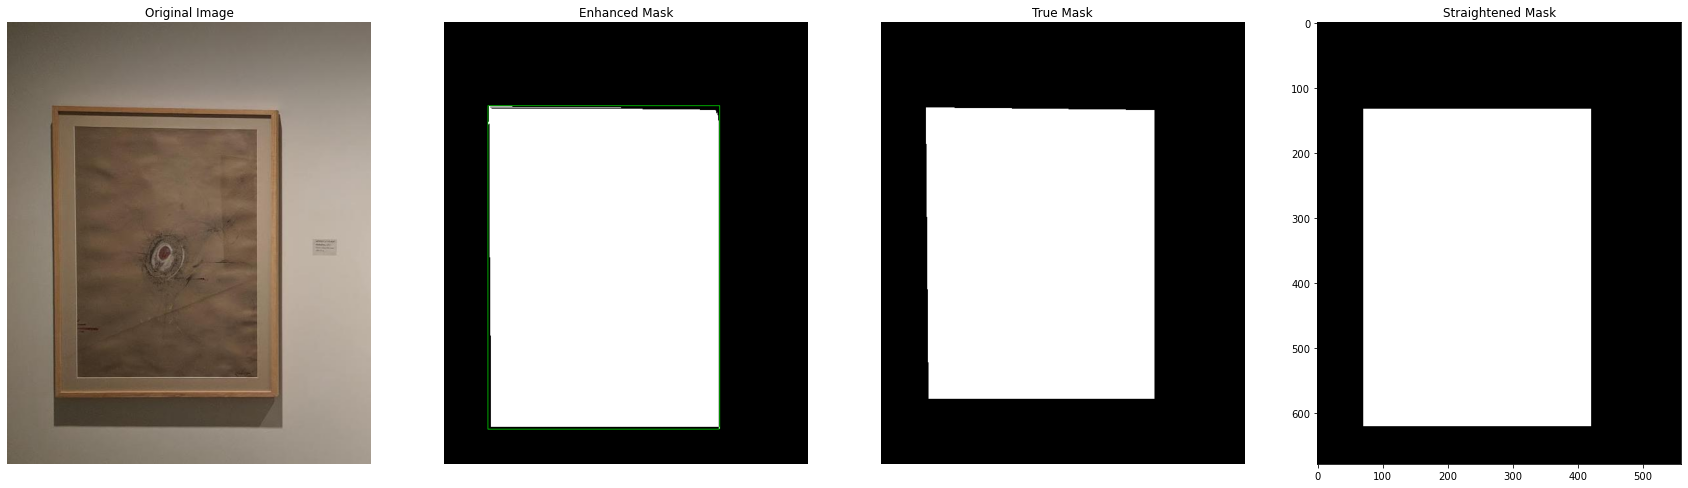

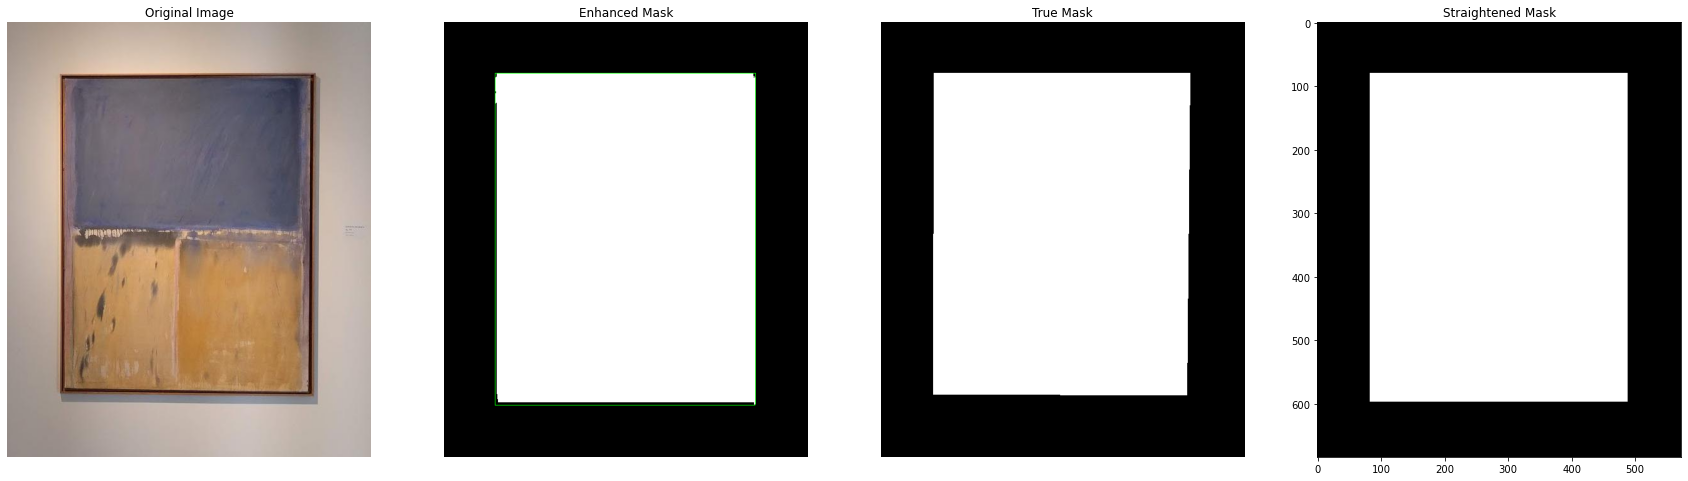

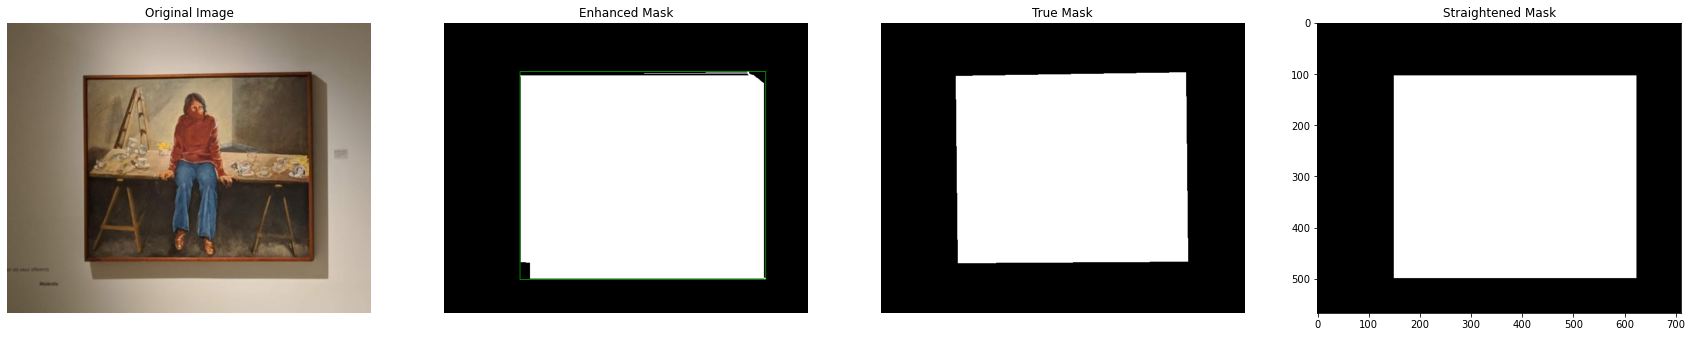

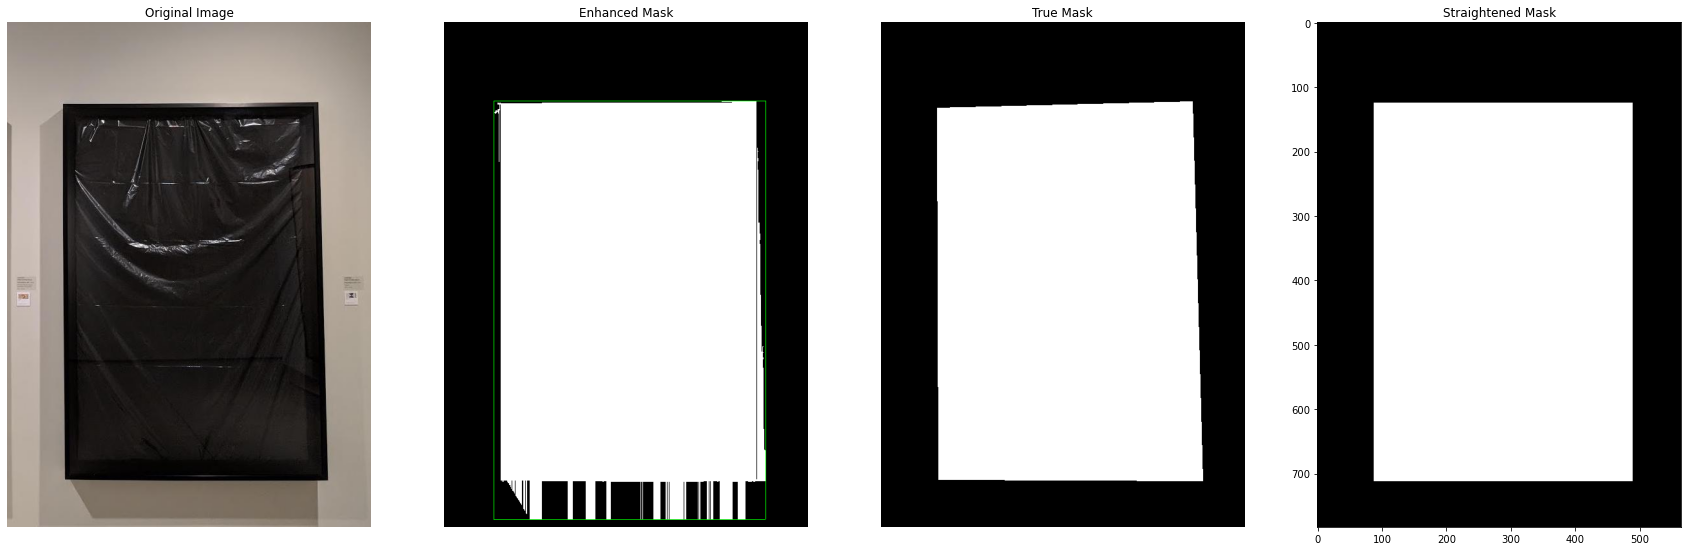

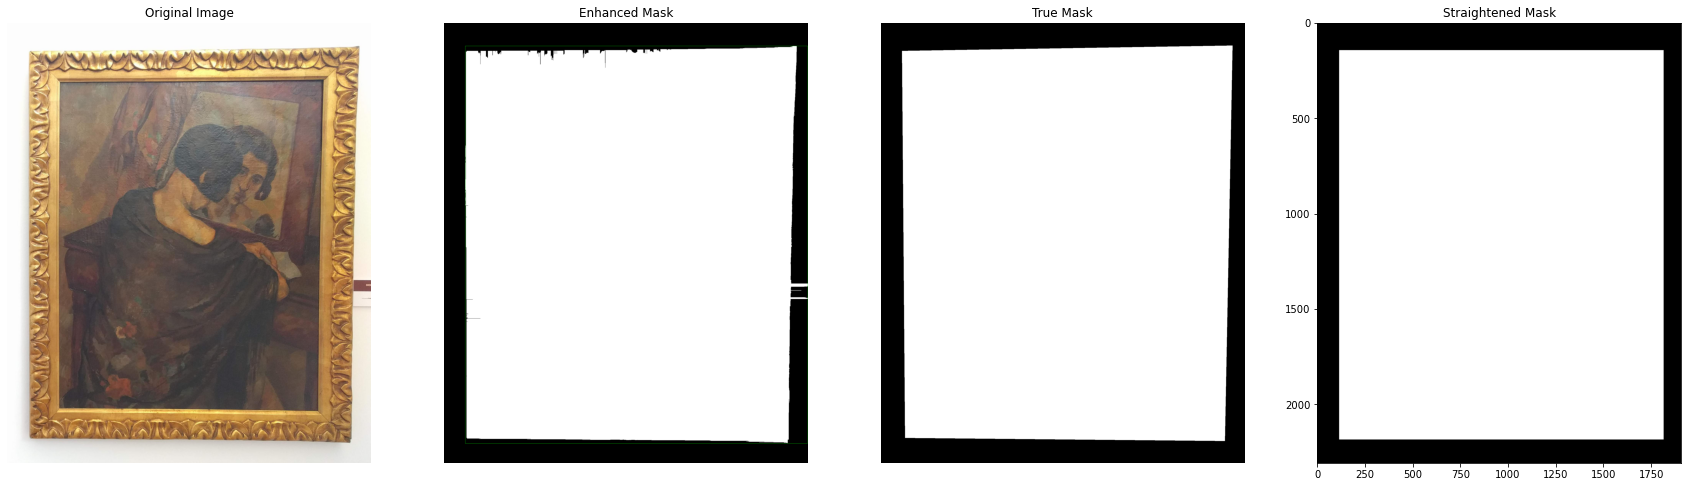

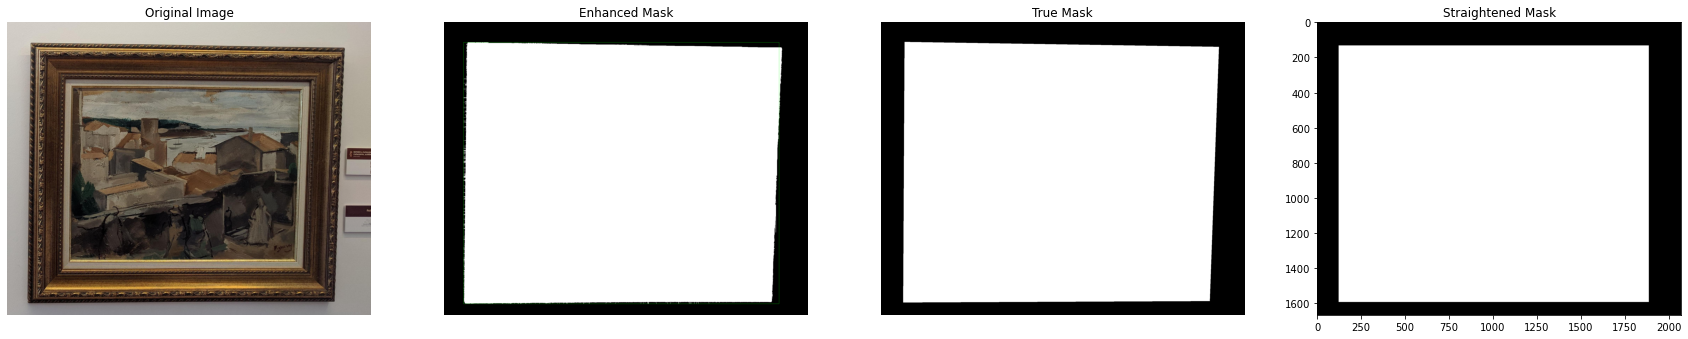

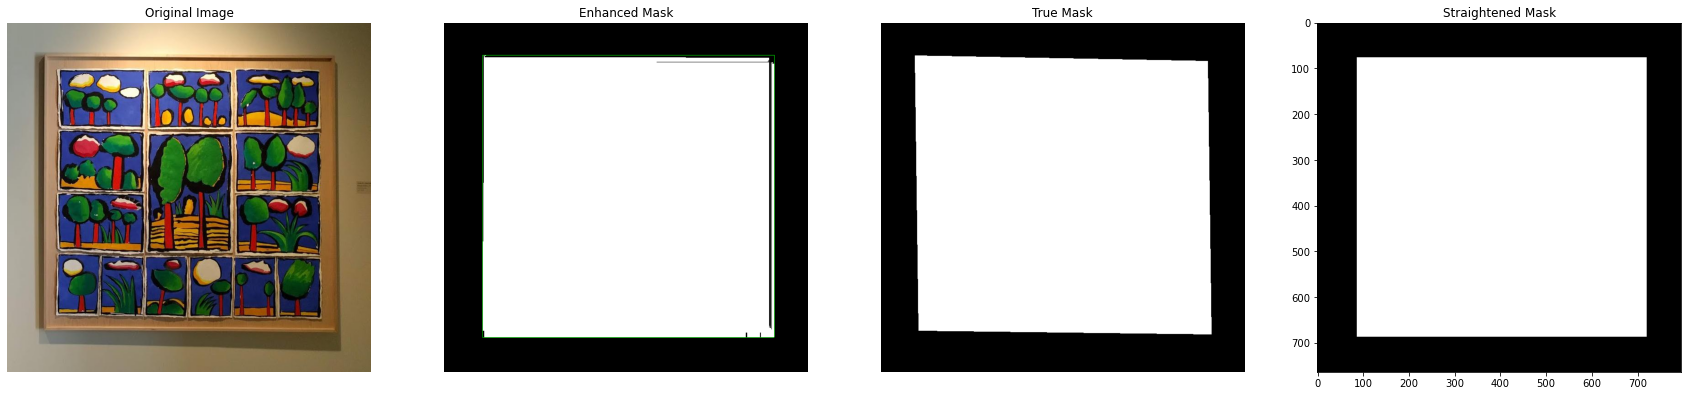

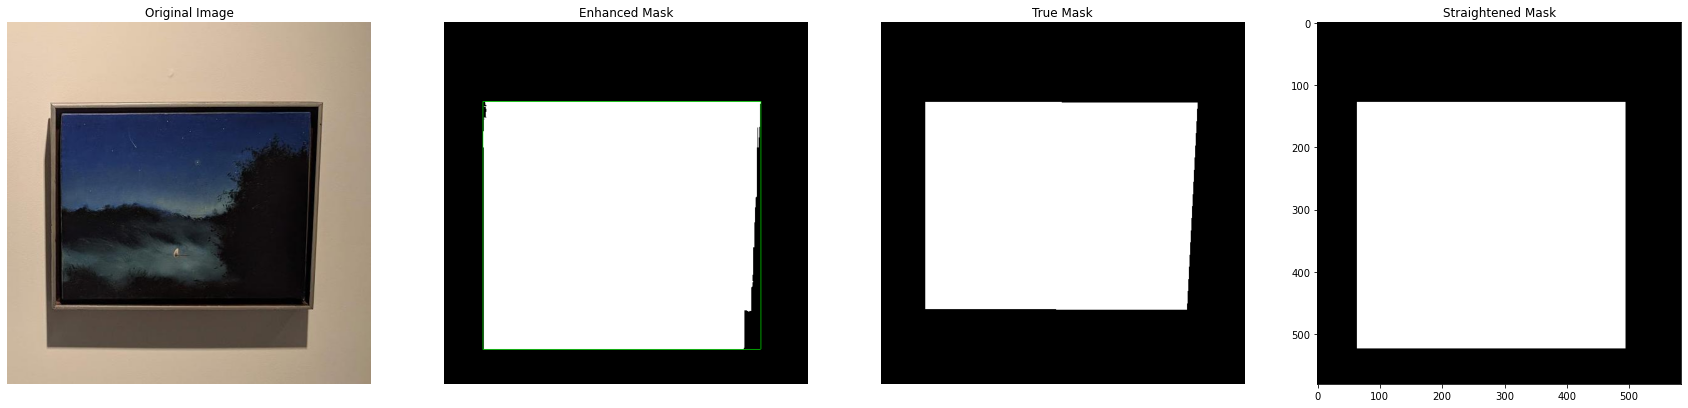

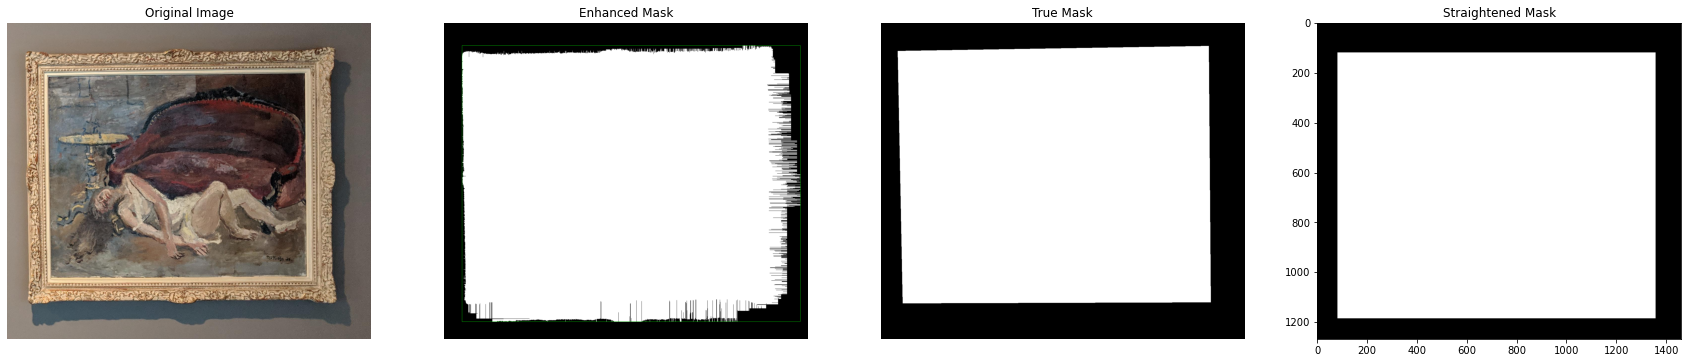

In [32]:
RUN_ALL = True

if RUN_ALL :

    for idx, image in enumerate(query_set2_imgs[:20]):
        true_mask = query_set2_masks[idx]
        predicted_mask = background_removal(image)
        enhanced_mask = (enhance_mask(predicted_mask)*255).astype("uint8")
        contours,_ = cv2.findContours(enhanced_mask, 1, 2)
        cnt = contours[0]
        y,x,w,h = cv2.boundingRect(cnt)
        w,h = min(w, mask.shape[1]-y-2), min(h, mask.shape[0]-x-2) 

        enhanced_mask = cv2.cvtColor(enhanced_mask, cv2.COLOR_GRAY2RGB)
        enhanced_mask[x,y:(y+w),:] = [0,255,0]
        enhanced_mask[x+h,y:(y+w),:] = [0,255,0]    
        enhanced_mask[x:x+h,y,:] = [0,255,0]
        enhanced_mask[x:x+h,(y+w),:] = [0,255,0]

        enhanced_mask_2,_ = enhance_mask_2(predicted_mask)

        f, axs = plt.subplots(1,4, figsize=(30,10))
        axs[0].imshow(cv2.cvtColor(image, color_spaces["RGB"]))
        axs[0].title.set_text("Original Image")
        axs[1].imshow(enhanced_mask)
        axs[1].title.set_text("Enhanced Mask")
        axs[2].imshow(true_mask, cmap="gray")
        axs[2].title.set_text("True Mask")
        axs[3].imshow(enhanced_mask_2, cmap="gray")
        axs[3].title.set_text("Straightened Mask")

        axs[0].axis('off')
        axs[1].axis('off')
        axs[2].axis('off')